In [515]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt

In [574]:
from sklearn import preprocessing
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import seaborn as sns ; sns.set()

In [575]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchvision import datasets, transforms
#from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [604]:
# Training settings
class Args:
    batch_size=1
    test_batch_size=150
    epochs=12
    lr=0.05
    #momentum=0.5
    momentum=0.0
    no_cuda=False
    seed=1
    log_interval=100
    save_checkpoints=True
    load_checkpoint=None #'mnist_012.pth'

args = Args
use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Generate Two Moons Dataset
Chapter 18 of Glassner's book describes his datset as follows (note the normalization that occurs):

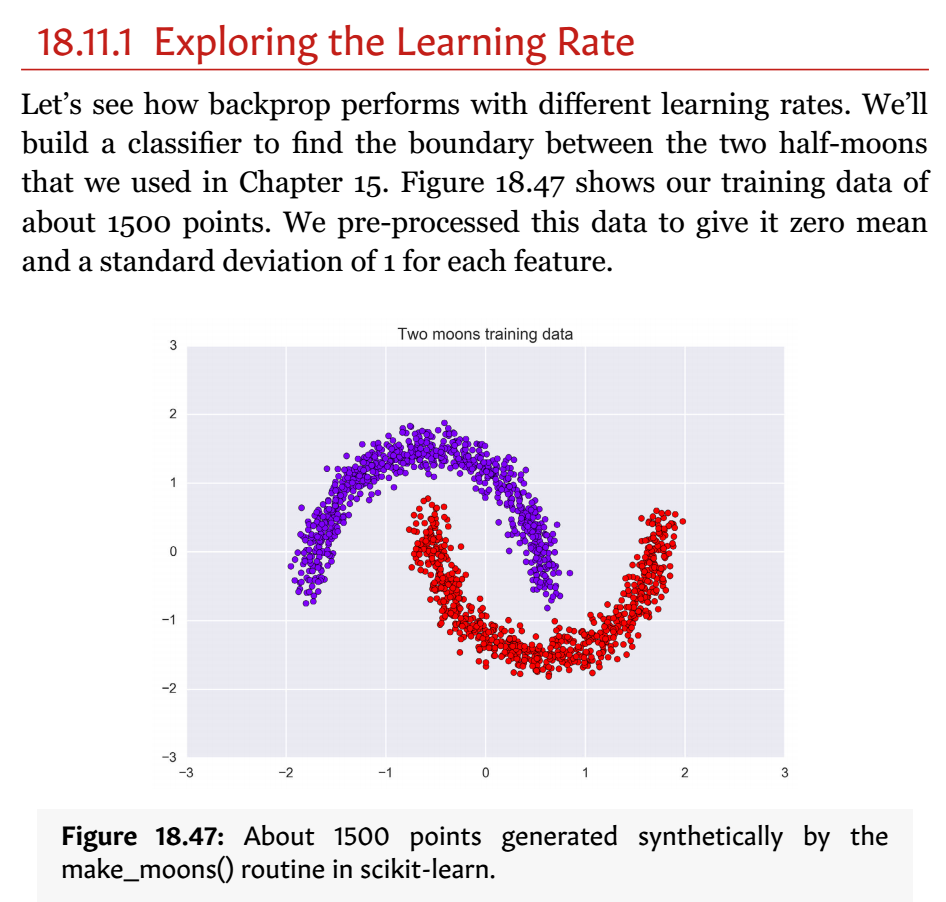

### Define the Dataset class

In [605]:
class TwoMoonsDataset(Dataset):
    """Two Moons dataset."""

    def __init__(self, noise=0.08, n_samples=1500):
        """
        Args:
            noise (float): Amount of noise to use.
            n_samples (int): Number of samples to generate.
        """
        np.random.seed(42)
        (moons_xy, moons_labels) = make_moons(n_samples=n_samples, noise=noise)
        self.sample = preprocessing.scale(moons_xy.astype(float))
        self.target = moons_labels

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return (self.sample[idx], self.target[idx])

### Create the training set and test set loaders
Here we test on the same data we train with

In [618]:
# DataLoaders for train and test data
train_loader = torch.utils.data.DataLoader(TwoMoonsDataset(n_samples=1500, noise=0.08), batch_size=args.batch_size, **kwargs)
test_loader = torch.utils.data.DataLoader(TwoMoonsDataset(n_samples=1500, noise=0.08), batch_size=1500, **kwargs)

### Plot the two datasets to make sure they look right

In [619]:
def plot_moons(dataset, title):
    clr_list = ['#8800FF', '#FF0000']
    clrs = [clr_list[v] for v in dataset.target]

    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.scatter(dataset.sample[:,0], dataset.sample[:,1], c=clrs, s=15, linewidths=0.5, edgecolors='k')

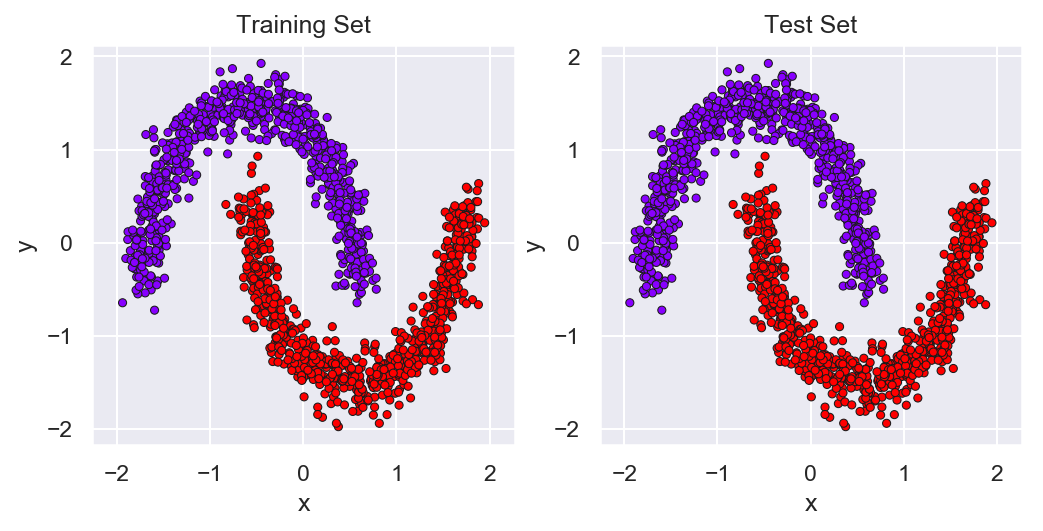

In [620]:
plt.figure(figsize=(8,12), dpi=150)
plt.subplot(3, 2, 1)
plot_moons(train_loader.dataset, 'Training Set')

plt.subplot(3, 2, 2)
plot_moons(test_loader.dataset, 'Test Set')

# Create Two-Layer Network
As noted below, Andrew Glassner includes a bias term in each activation and the network has a total of 37 parameters

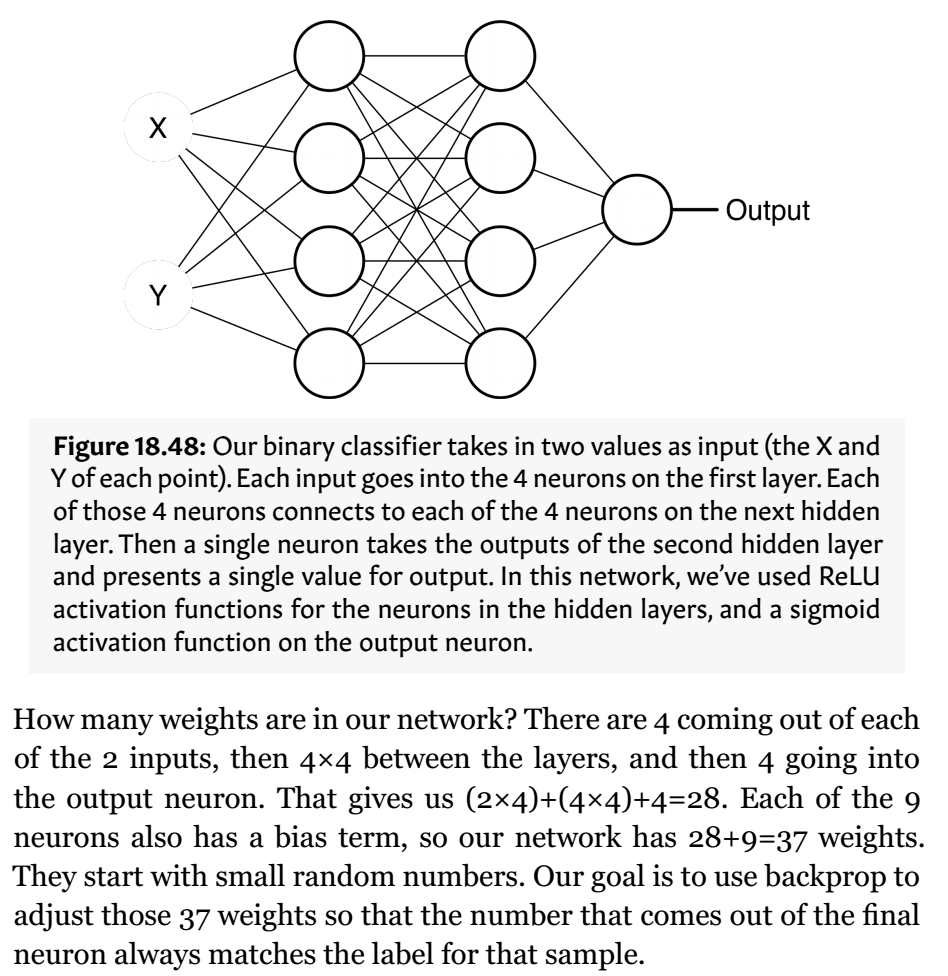

In [621]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 4, bias=True)
        self.fc2 = nn.Linear(4, 4, bias=True)
        self.fc3 = nn.Linear(4, 1, bias=True)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

In [622]:
device = torch.device("cpu")
model = Net().float().to(device)

### Print Network Dimensions and Weights
We show 37 parameters below, which matches Glassners

In [623]:
def print_model_size(model):
    total_model_size = 0
    print("Model's state_dict:\n")
    # print out size of each set of parameter
    for param_tensor in model.state_dict():
        sz = model.state_dict()[param_tensor].size()

        # skip empty parameters (like batch normalization history length)
        if len(sz) == 0:
            continue

        total_model_size += np.prod(sz)
        if len(sz) > 1:
            print('{:16s} {:26s} : {} x {} = {:,}'.format(param_tensor, str(sz), sz[0], np.prod(sz[1:]), np.prod(sz)))
        else:
            print('{:16s} {:26s} : {:,}'.format(param_tensor, str(sz), np.prod(sz)))
        print('{}\n'.format(model.state_dict()[param_tensor]))
        
    # print out total
    print('\n{:43} : {:,}'.format('Total Model Size',total_model_size))

In [624]:
print_model_size(model)

Model's state_dict:

fc1.weight       torch.Size([4, 2])         : 4 x 2 = 8
tensor([[-0.4095, -0.6286],
        [ 0.5146, -0.1049],
        [ 0.3977,  0.2273],
        [-0.5302,  0.1421]])

fc1.bias         torch.Size([4])            : 4
tensor([ 0.1698, -0.4734, -0.3355,  0.2411])

fc2.weight       torch.Size([4, 4])         : 4 x 4 = 16
tensor([[ 0.0896, -0.2127, -0.1514,  0.4579],
        [-0.0925,  0.2819,  0.2165, -0.3232],
        [-0.4252,  0.4799,  0.0261,  0.3427],
        [ 0.1036,  0.1608,  0.3735,  0.4741]])

fc2.bias         torch.Size([4])            : 4
tensor([-0.3318,  0.0625,  0.3731,  0.3622])

fc3.weight       torch.Size([1, 4])         : 1 x 4 = 4
tensor([[ 0.3106, -0.3619, -0.3601, -0.3024]])

fc3.bias         torch.Size([1])            : 1
tensor([0.0628])


Total Model Size                            : 37


### Visualize Cost Landscape

# Train the Network

In [625]:
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
#optimizer = optim.Adadelta(model.parameters())
loss_criterion = nn.MSELoss()
#loss_criterion = nn.CrossEntropyLoss(reduction='sum')

In [626]:
def train(args, model, device, train_loader, optimizer, epoch):
    # Set model to be in training mode
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data.float())
        loss = loss_criterion(output, target.float())
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{:5}/{} ({:3.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()/len(data)))

In [627]:
def test(args, model, device, test_loader):
    # Set model to be in testing mode
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data.float())
            test_loss += loss_criterion(output, target.float()).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [628]:
def run_epoch(args, model, device, train_loader, test_loader, optimizer, epoch):
    train_start = time.perf_counter()
    train(args, model, device, train_loader, optimizer, epoch)
    train_end = time.perf_counter()
    train_delta = train_end - train_start

    test_start = time.perf_counter()
    test(args, model, device, test_loader)
    test_end = time.perf_counter()
    test_delta = test_end - test_start
    
    print("Training took {:.1f}s.".format(train_delta))
    print("Testing took {:.1f}s.\n".format(test_delta))   

In [629]:
for epoch in range(1, args.epochs + 1):
    run_epoch(args, model, device, train_loader, test_loader, optimizer, epoch)

Train Epoch: 1 [    0/1500 (  0%)]	Loss: 0.268966
Train Epoch: 1 [  100/1500 (  7%)]	Loss: 0.239497
Train Epoch: 1 [  200/1500 ( 13%)]	Loss: 0.173960
Train Epoch: 1 [  300/1500 ( 20%)]	Loss: 0.035878
Train Epoch: 1 [  400/1500 ( 27%)]	Loss: 0.075512
Train Epoch: 1 [  500/1500 ( 33%)]	Loss: 0.000755
Train Epoch: 1 [  600/1500 ( 40%)]	Loss: 0.004976
Train Epoch: 1 [  700/1500 ( 47%)]	Loss: 0.426234
Train Epoch: 1 [  800/1500 ( 53%)]	Loss: 0.179254
Train Epoch: 1 [  900/1500 ( 60%)]	Loss: 0.610546
Train Epoch: 1 [ 1000/1500 ( 67%)]	Loss: 0.189212
Train Epoch: 1 [ 1100/1500 ( 73%)]	Loss: 0.000443
Train Epoch: 1 [ 1200/1500 ( 80%)]	Loss: 0.002684
Train Epoch: 1 [ 1300/1500 ( 87%)]	Loss: 0.031991
Train Epoch: 1 [ 1400/1500 ( 93%)]	Loss: 0.020753

Test set: Average loss: 0.0003, Accuracy: 750/1500 (50%)
Training took 0.7s.
Testing took 0.0s.

Train Epoch: 2 [    0/1500 (  0%)]	Loss: 0.018380
Train Epoch: 2 [  100/1500 (  7%)]	Loss: 0.017845
Train Epoch: 2 [  200/1500 ( 13%)]	Loss: 0.016741
Tr

Train Epoch: 10 [ 1400/1500 ( 93%)]	Loss: 0.002329

Test set: Average loss: 0.0003, Accuracy: 750/1500 (50%)
Training took 0.7s.
Testing took 0.0s.

Train Epoch: 11 [    0/1500 (  0%)]	Loss: 0.002225
Train Epoch: 11 [  100/1500 (  7%)]	Loss: 0.002240
Train Epoch: 11 [  200/1500 ( 13%)]	Loss: 0.003355
Train Epoch: 11 [  300/1500 ( 20%)]	Loss: 0.000243
Train Epoch: 11 [  400/1500 ( 27%)]	Loss: 0.002115
Train Epoch: 11 [  500/1500 ( 33%)]	Loss: 0.000001
Train Epoch: 11 [  600/1500 ( 40%)]	Loss: 0.000881
Train Epoch: 11 [  700/1500 ( 47%)]	Loss: 0.165737
Train Epoch: 11 [  800/1500 ( 53%)]	Loss: 0.015484
Train Epoch: 11 [  900/1500 ( 60%)]	Loss: 0.566436
Train Epoch: 11 [ 1000/1500 ( 67%)]	Loss: 0.445862
Train Epoch: 11 [ 1100/1500 ( 73%)]	Loss: 0.000007
Train Epoch: 11 [ 1200/1500 ( 80%)]	Loss: 0.000918
Train Epoch: 11 [ 1300/1500 ( 87%)]	Loss: 0.004130
Train Epoch: 11 [ 1400/1500 ( 93%)]	Loss: 0.002248

Test set: Average loss: 0.0003, Accuracy: 750/1500 (50%)
Training took 0.8s.
Testing 

In [463]:
test_loader.dataset.sample[0]

array([-1.04185228, -0.07716311])

In [ ]:
np.random.seed(42)
plt.figure(figsize=(8,12), dpi=150)

plt.subplot(3, 2, 1)
plt.axis('equal')
(moons_xy, moons_labels) = make_moons(n_samples=1500)
clrs = [clr_list[v] for v in moons_labels]
plt.scatter(moons_xy[:,0], moons_xy[:,1], c=clrs, s=15, linewidths=0.5, edgecolors='k')
plt.title('make_moons(), 0 noise')